In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

In [158]:
x = torch.tensor(0., requires_grad=True)
a = 2*x
b = 3*x
a.backward()
b.backward()
print(x.grad)

tensor(5.)


In [173]:
def produce_plots(df,lb, q1=0.25,q2=0.75):
    q1 = q1
    q2 = q2
    q3 = 0.5

    means = df.groupby('iteration').mean()
    q_lower = df.groupby(by='iteration').quantile(q=q1,interpolation='lower')
    q_mid = df.groupby(by='iteration').quantile(q=q3,interpolation='linear')
    q_higher = df.groupby(by='iteration').quantile(q=q2,interpolation='higher')
    
    f = plt.figure()
    
    ax1 = f.add_subplot()

    ax1.fill_between(x=range(len(means)), y1=q_lower['Loss'], y2=q_higher['Loss'],alpha=0.4)
    ax1.plot(q_lower['Loss'], label=f'Q{int(q1*100)}',c='black')
    ax1.plot(q_higher['Loss'], label=f'Q{int(q2*100)}',c='black')
    ax1.plot(q_mid['Loss'], label=f'Q{int(q3*100)}',c='black')
    ax1.plot(means['Loss'], label='Mean')
    xt = ax1.get_xticks()
    xt_ind = xt[1:-1] - 1
    xt_ind[0] = 0
    # ax1.set_xticks(means['SampleSize'].cumsum()[xt_ind])
    # ax1.set_xticklabels(labels=np.round(means['SampleSize'].cumsum()[xt_ind], 0), rotation=45)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    f = plt.figure()
    ax2 = f.add_subplot()

    ax2.fill_between(x=range(len(means)), y1=q_lower['C1'], y2=q_higher['C1'],alpha=0.4)
    ax2.plot(q_lower['C1'], ls = '-', label=f'Q{int(q1*100)}',c='black')
    ax2.plot(q_higher['C1'], ls = '-', label=f'Q{int(q2*100)}',c='black')
    ax2.plot(q_mid['C1'], label=f'Q{int(q3*100)}',c='black')
    ax2.plot(means['C1'], label='Mean')

    ax2.set_xlabel('Iteration')
    # ax2.set_ylim(bottom=-0.02, top=0.02)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=len(means), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=len(means), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    ax2.legend()
    
    plt.show()
    
def plot_separate_trajectories(data, lb, alpha=0.5, lw=1, legend=True):
    f = plt.figure()
    ax1 = f.add_subplot()
    f = plt.figure()
    ax2 = f.add_subplot()
    for EXP_NUM in data['trial'].unique():
        traj = data[data['trial'] == EXP_NUM]
        ax1.plot(traj['iteration'], traj['Loss'], label='Loss - trial {EXP_NUM}', alpha=alpha, lw=lw)
        ax2.plot(traj['iteration'], traj['C1'], label=f'C1 - trial {EXP_NUM}', alpha=alpha, lw=lw)
    
    ax2.set_xlabel('Iteration')
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=len(traj.index), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=len(traj.index), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    if legend:
        ax2.legend()
    f.show()

In [189]:
DATASET = 'employment_az'
lb = 0.005
geomp = 0.05
sampling = 1
alg = 'sslalm'

if alg.startswith('sg'):
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}_{geomp}_REPORT.csv'
else:
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}_{sampling}_REPORT.csv'
    
stats = pd.read_csv(filename)
stats_train = stats[stats['is_train'] == 'train'].drop(['is_train'], axis=1)
stats_test = stats[stats['is_train'] == 'test'].drop(['is_train'], axis=1)

In [190]:
stats_test

,iteration,trial,Loss,C1,C2,SampleSize
0,0,0,0.692358,0.000176,-0.000176,1.0
1,1,0,0.692393,0.000172,-0.000172,1.0
2,2,0,0.692316,0.000197,-0.000197,1.0
3,3,0,0.692381,0.000165,-0.000165,1.0
4,4,0,0.692434,0.000151,-0.000151,1.0
...,...,...,...,...,...,...
55987,55987,0,0.424499,0.000875,-0.000875,1.0
55988,55988,0,0.424484,0.000865,-0.000865,1.0
55989,55989,0,0.424747,0.000903,-0.000903,1.0
55990,55990,0,0.425086,0.001017,-0.001017,1.0


C:\Users\andre\AppData\Local\Temp\ipykernel_15424\1104691117.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


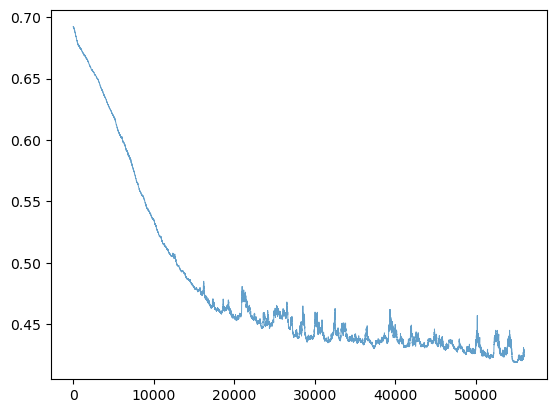

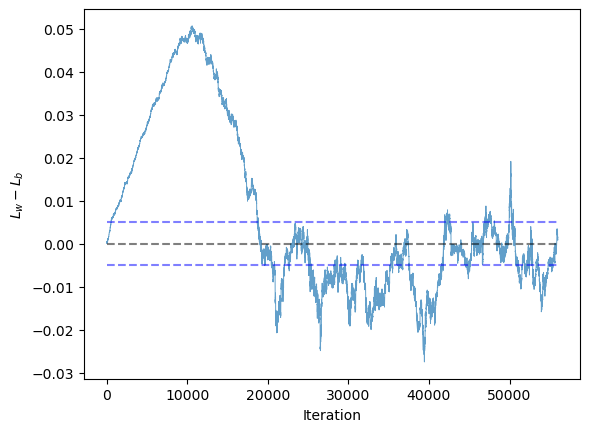

In [191]:
plot_separate_trajectories(stats_test, lb, alpha=0.7, lw=0.7, legend=False)

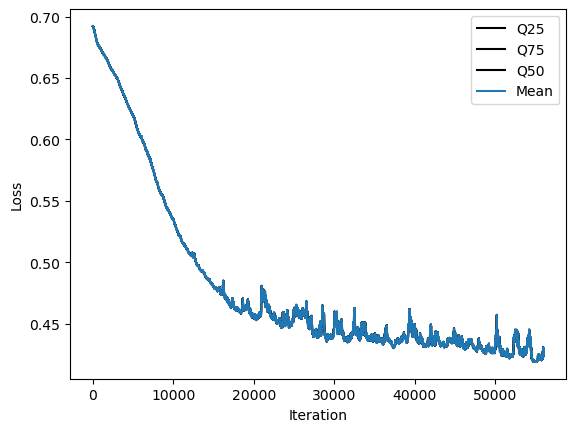

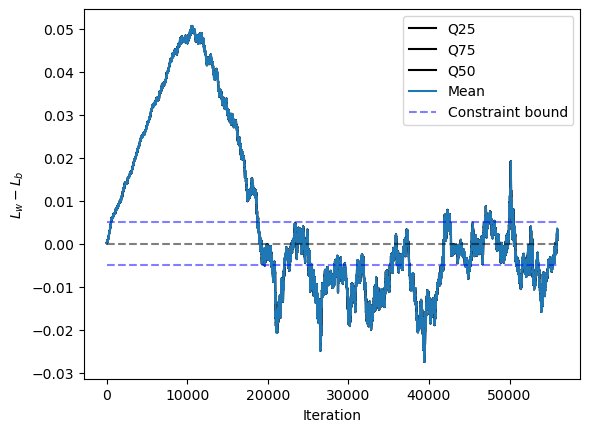

In [192]:
produce_plots(stats_test, lb)

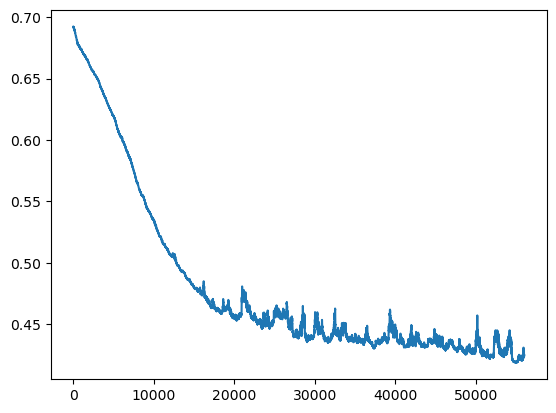

In [193]:
stats_test['CumSampleSize'] = stats_test.groupby('trial')['SampleSize'].cumsum()
by_css = stats_test.groupby('CumSampleSize')
by_css_mean = by_css.mean()
by_css_qlow = by_css.quantile(q=0,interpolation='lower')
by_css_qupp = by_css.quantile(q=1,interpolation='higher')

f = plt.figure()
ax1 = f.add_subplot()
ax1.plot(by_css_mean['Loss'])

# ax1.fill_between(x=by_css_mean.index.to_numpy(), y1=by_css_qlow['Loss'], y2=by_css_qupp['Loss'],alpha=0.4)
# ax1.plot(by_css_mean.index.to_numpy(), by_css_mean['Loss'])
# ax1.plot(by_css_mean.index.to_numpy(),by_css_qlow['Loss'], c='blue')
# ax1.plot(by_css_mean.index.to_numpy(),by_css_qupp['Loss'],alpha=0.3)